# Field Reversed Configuration (FRC) Simulations

The FRC formed through an RMF can be characterized by two important dimensionless parameters, $\lambda=R/\delta$, where $\delta=(2\eta /\mu_o \omega)^{1/2}$ is the classical skin depth, and by $\gamma=\omega_{ce}/\nu_{ei}$, where $\nu_{ei}=\eta(ne^2/m_e)$ is the electron-ion collision frequency. In term of the system parameters, these two parameters can be expressed as

$$ \lambda = R \left(\frac{\mu_o\omega}{2\eta}\right)^{1/2} $$,

$$ \gamma = \frac{1}{e}\left(\frac{B_\omega}{n\eta}\right) $$.

The magnitude of the external-driving field must exceed a certain critical value before much current is driven in the plasma column.

The measure of the current drive is the parameter $\alpha$, which is defined as the ratio of the driven current divided by the current obtained if all of the electrons rotate synchronously with the RMF.

$$ \alpha = \frac{2}{\mu_o n e \omega R^2}\left(B_z(r=R) - B(r=0) \right) $$

In [64]:
#######  IMPORTS ###########
import os
import re
import vtk

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from vtk.util.numpy_support import vtk_to_numpy

# import pandas and seaborn
import pandas as pd
import seaborn as sns

# import keras functions
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

#import scikit-learn function
from sklearn.preprocessing import StandardScaler

/usr/lib/pymodules/python2.7/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


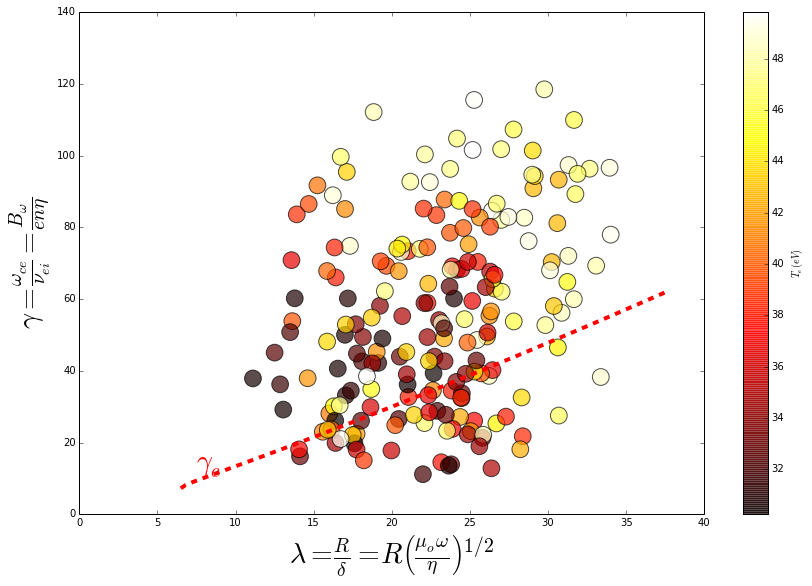

In [2]:
number = 200 # Sample size

def calRatio(w, Bw, Te):
    mu_o = np.pi*4.e-7
    e = 1.602e-19

    n = 1.0e20
    R = 0.03
    loglambda = 10.

    eta = 5.2e-5*loglambda/(Te)**1.5
    #eta = 1.65e-9*loglambda/(Te/1.e3)**1.5

    gamma = Bw/e/n/eta
    lmbda = R*np.sqrt(0.5*mu_o*w/eta)

    return gamma, lmbda

def gammaCritical(lbd):
    return 1.12*lbd*(1.0+0.12*(lbd-6.5)**0.4)

def getSelectionInRange(var, rmin, rmax, sample):
    a = np.where(var>rmin)
    b = np.where(var<rmax)
    intersec = np.intersect1d(a,b)

    if(sample<len(intersec)):
        randSample = np.random.randint(len(intersec), size=sample)
        res = intersec[randSample]
    else:
        res = intersec

    return res

omega = np.zeros(number)
Bomega= np.zeros(number)
Temp  = np.zeros(number)
lam   = np.zeros(number)
gam   = np.zeros(number)
gol   = np.zeros(number)

np.random.seed(4)
for k in range(number):
    omega[k] = np.random.uniform(2*np.pi*1.e5,2*np.pi*5.e5)
    Bomega[k]= np.random.uniform(5.e-4,30.e-4)
    Temp[k]  = np.random.uniform(30.,50.)
    gam[k], lam[k]   = calRatio(omega[k], Bomega[k], Temp[k])
    gol[k] = gam[k]/lam[k]

plt.figure(figsize=(14,9))
sc = plt.scatter(lam, gam, c=Temp, cmap="hot", alpha=0.7,s=280)

cb = plt.colorbar(sc, label=r'$T_e (eV)$')
plt.legend()
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.plot([0.2*pi,3.3],[1.,1.],'k--',lw=2.)
#plt.xlim(0.2*pi,3.3)

xx = np.linspace(6.5,37.5,100)
yy = gammaCritical(xx)
plt.plot(xx,yy,'r--',lw=4.)
plt.text(7.5,12.,r"$\gamma_c$",fontsize=28,color='red')

For each of the points in the scatter plot an Apollo simulations was run.

In [39]:
time = 51
component = 0

# get a list of all sub-directories in thedir
thedir  = '/home/sousae/simulationsApollo/rmf_frc/dataAnalysis'
subdirs = [ name for name in os.listdir(thedir) if os.path.isdir(os.path.join(thedir, name)) ]
if '.ipynb_checkpoints' in subdirs: subdirs.remove('.ipynb_checkpoints') ### I get this weird sting in there somehow

frc = np.genfromtxt(os.path.join(thedir,subdirs[s])+'/frc_testSamplesData.txt')    
    
#reader = vtk.vtkXMLUnstructuredGridReader()

# this function extracts the RMF frequency, RMF field magnitude, and the electron temperature at initialization
#def getSimulationParameters(filename):
#    f=open(filename)
#    lines = f.readlines()
#    om = re.findall("\d+\.\d+",lines[2])
#    Bo = re.findall("\d+\.\d+",lines[3])
#    Te = re.findall("\d+\.\d+",lines[4])
    
#    return float(om[0]), float(Bo[0]), float(Te[0])
    
#################### this is used to get the dimensions of the dataset per output file #####
#d = np.loadtxt(thedir+'/simulation_values.txt')
#folder = 'gammaOverGamma_crit_0.804947683677'
#filename = os.path.join(thedir,folder)+'/frc2d_2Fluid_000.vtu'
#reader = vtk.vtkXMLUnstructuredGridReader()
#reader.SetFileName(filename)
#reader.Update()
#size = len( vtk_to_numpy( reader.GetOutput().GetPointData().GetArray(component) ) )
############################################################################################

#dataB = np.zeros((size,time))
#dataR = np.zeros((size,time))
#minBz= np.zeros(time)

#frc = np.zeros((len(subdirs),12))

# Loop over all sample test cases
#for s in range(len(subdirs)):
    # get the values of omega, b_omega, and Te for this sample
#    frc[s,0], frc[s,1], frc[s,2] = getSimulationParameters(os.path.join(thedir,subdirs[s])+'/frc2d.pin')
    #calculate gamma, lambda and gamma/gammaCritical
#    frc[s,4], frc[s,3]   = calRatio(frc[s,0], frc[s,1], frc[s,2])
#    frc[s,5] = frc[s,4]/gammaCritical(frc[s,3])
    
    # loop over all time slices
#    for k in range(time):
#        filename = os.path.join(thedir,subdirs[s])+'/frc2d_2Fluid_'+str('%03d' % k)+'.vtu'
#        reader.SetFileName(filename)
#        reader.Update()
#        dataB[:,k] = vtk_to_numpy(reader.GetOutput().GetPointData().GetArray(15)) # Bz
#        dataR[:,k] = vtk_to_numpy(reader.GetOutput().GetPointData().GetArray(0)) # electron density
#        minBz[k]  = min(dataB[:,k])
        
    ### Do a SVD
#    U, sB, V = np.linalg.svd(dataB, full_matrices=False)
#    U, sR, V = np.linalg.svd(dataR, full_matrices=False)
    
    ### Get the first singular value for Bz SVD
#    frc[s,6] = sB[0]
#    frc[s,7] = sB[0]/sB.sum()
    
    ### Get the first singular value for rho_e SVD
#    frc[s,8] = sR[0]
#    frc[s,9] = sR[0]/sR.sum()
    
#    frc[s,10] = dataB.min()
#    frc[s,11] = (1. if dataB.min() < 0. else 0.)
#plt.figure(figsize=(14,9))
#plt.subplot(421), plt.plot(s/sum(s),'bo', markersize=12)
#plt.subplot(423), plt.plot(U[:,0],'b',lw=2)
#plt.subplot(425), plt.plot(U[:,1],'r',lw=2)
#plt.subplot(427), plt.plot(U[:,2],'g',lw=2)

#plt.subplot(422), plt.plot(minBz,lw=2)
#plt.subplot(422), plt.plot(plasmaFreqe,'r',lw=2)
#plt.subplot(422), plt.plot(plasmaFreqi,'g',lw=2)
#plt.subplot(422), plt.plot(plasmaFreqp,'m',lw=2)
#plt.subplot(424), plt.plot(V[0,:],'b',lw=2)
#plt.subplot(426), plt.plot(V[1,:],'r',lw=2)
#plt.subplot(428), plt.plot(V[2,:],'g',lw=2)
#np.savetxt(os.path.join(thedir,subdirs[s])+'/frc_testSamplesData.txt', frc)
print('Done.')

Done.


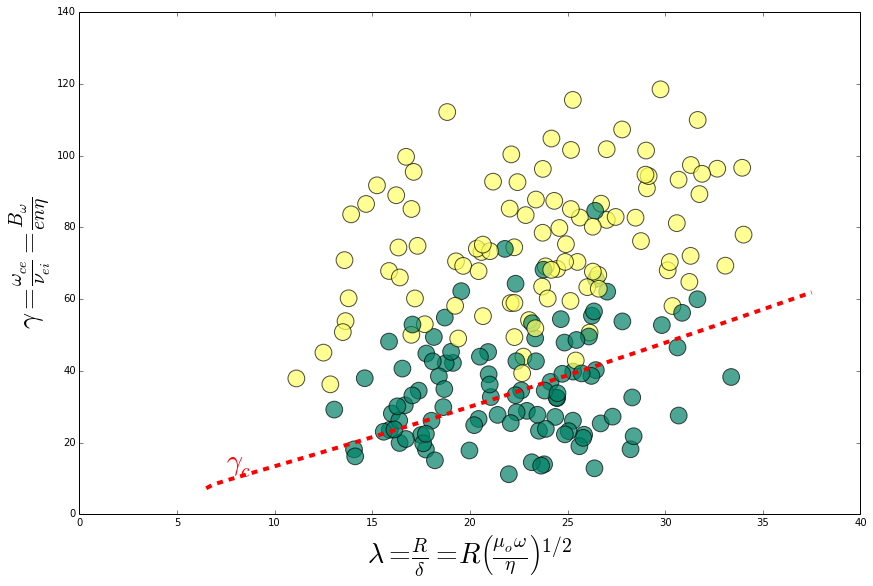

In [40]:
plt.figure(figsize=(14,9))
sc = plt.scatter(frc[:,3], frc[:,4], c=frc[:,11], cmap="summer", alpha=0.7,s=280)

#cb = plt.colorbar(sc, label=r'$B_z Reversal$')
#plt.legend()
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.plot([0.2*pi,3.3],[1.,1.],'k--',lw=2.)
#plt.xlim(0.2*pi,3.3)

xx = np.linspace(6.5,37.5,100)
yy = gammaCritical(xx)
plt.plot(xx,yy,'r--',lw=4.)
plt.text(7.5,12.,r"$\gamma_c$",fontsize=28,color='red')

In [41]:
df = pd.DataFrame(frc, columns=['omega', 'Bomega', 'Te', 'lambda', 'gamma', 'gammaOverCrit', 'svd_bz', 
                                'svd_bz_per', 'svd_rho', 'svd_rho_perc', 'minBz', 'reversal'])

df["Bz_negative"] = df['reversal'].astype('category')

In [37]:
#fig, ax = plt.subplots(figsize=(14,9))
#sns.lmplot(x= 'lambda', y= 'gamma', data=df, hue='Bz_negative', palette='Set1', size=280)

The prediction pattern is complex, therefore a ddep learning neural network will be developed in an attempt to predict the test cases reversal.

In [133]:
# setup need variables

predictors = frc[:,0:5]
target = to_categorical(frc[:,11])


n_cols = predictors.shape[1]

# scale the predictors
scaler = StandardScaler()
scaler.fit(predictors)
predictors_scaled = scaler.transform(predictors)

def create_model_given_activation(act, predict=predictors_scaled, targ=target, ncols=n_cols):
    model = Sequential()
    model.add(Dense(20, activation=act, input_shape = (ncols,)))
    model.add(Dense(14, activation=act))
    model.add(Dense(8, activation=act))
    model.add(Dense(2, activation='softmax'))
    
    # compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # fit the model with early stopping
    early_stopping_monitor = EarlyStopping(patience=2)
    history = model.fit(predict, targ, validation_split=0.3, epochs=30,
                        callbacks = [early_stopping_monitor])
    
    return history    

In [138]:
# create a model
activation = 'relu'

history = create_model_given_activation(activation)

Train on 140 samples, validate on 60 samples
Epoch 1/30
140/140 [==============================] - 1s 4ms/step - loss: 0.6314 - acc: 0.5429 - val_loss: 0.6301 - val_acc: 0.4667
Epoch 2/30
140/140 [==============================] - 0s 63us/step - loss: 0.6041 - acc: 0.6286 - val_loss: 0.6030 - val_acc: 0.6667
Epoch 3/30
140/140 [==============================] - 0s 124us/step - loss: 0.5797 - acc: 0.7714 - val_loss: 0.5765 - val_acc: 0.8333
Epoch 4/30
140/140 [==============================] - 0s 128us/step - loss: 0.5568 - acc: 0.8500 - val_loss: 0.5512 - val_acc: 0.9500
Epoch 5/30
140/140 [==============================] - 0s 158us/step - loss: 0.5360 - acc: 0.8857 - val_loss: 0.5280 - val_acc: 0.9500
Epoch 6/30
140/140 [==============================] - 0s 156us/step - loss: 0.5160 - acc: 0.8857 - val_loss: 0.5059 - val_acc: 0.9667
Epoch 7/30
140/140 [==============================] - 0s 141us/step - loss: 0.4965 - acc: 0.9000 - val_loss: 0.4811 - val_acc: 0.9833
Epoch 8/30
140/140 [

In [139]:
# create a new model
activation = 'linear'

history2 = create_model_given_activation(activation)

Train on 140 samples, validate on 60 samples
Epoch 1/30
140/140 [==============================] - 1s 5ms/step - loss: 0.6255 - acc: 0.6143 - val_loss: 0.5464 - val_acc: 0.7000
Epoch 2/30
140/140 [==============================] - 0s 63us/step - loss: 0.5135 - acc: 0.7357 - val_loss: 0.4257 - val_acc: 0.8500
Epoch 3/30
140/140 [==============================] - 0s 314us/step - loss: 0.4247 - acc: 0.8429 - val_loss: 0.3415 - val_acc: 0.9500
Epoch 4/30
140/140 [==============================] - 0s 222us/step - loss: 0.3672 - acc: 0.8714 - val_loss: 0.2809 - val_acc: 0.9833
Epoch 5/30
140/140 [==============================] - 0s 225us/step - loss: 0.3311 - acc: 0.8929 - val_loss: 0.2384 - val_acc: 0.9833
Epoch 6/30
140/140 [==============================] - 0s 234us/step - loss: 0.3017 - acc: 0.9000 - val_loss: 0.2097 - val_acc: 0.9833
Epoch 7/30
140/140 [==============================] - 0s 117us/step - loss: 0.2807 - acc: 0.9000 - val_loss: 0.1879 - val_acc: 1.0000
Epoch 8/30
140/140 [

In [140]:
activation = 'sigmoid'

history3 = create_model_given_activation(activation)

Train on 140 samples, validate on 60 samples
Epoch 1/30
140/140 [==============================] - 1s 5ms/step - loss: 0.7231 - acc: 0.5429 - val_loss: 0.7866 - val_acc: 0.4333
Epoch 2/30
140/140 [==============================] - 0s 65us/step - loss: 0.7127 - acc: 0.5429 - val_loss: 0.7695 - val_acc: 0.4333
Epoch 3/30
140/140 [==============================] - 0s 186us/step - loss: 0.7058 - acc: 0.5429 - val_loss: 0.7563 - val_acc: 0.4333
Epoch 4/30
140/140 [==============================] - 0s 216us/step - loss: 0.6996 - acc: 0.5429 - val_loss: 0.7468 - val_acc: 0.4333
Epoch 5/30
140/140 [==============================] - 0s 224us/step - loss: 0.6956 - acc: 0.5429 - val_loss: 0.7371 - val_acc: 0.4333
Epoch 6/30
140/140 [==============================] - 0s 197us/step - loss: 0.6924 - acc: 0.5429 - val_loss: 0.7280 - val_acc: 0.4333
Epoch 7/30
140/140 [==============================] - 0s 221us/step - loss: 0.6893 - acc: 0.5429 - val_loss: 0.7209 - val_acc: 0.4333
Epoch 8/30
140/140 [

In [141]:
activation = 'tanh'

history4 = create_model_given_activation(activation)

Train on 140 samples, validate on 60 samples
Epoch 1/30
140/140 [==============================] - 1s 5ms/step - loss: 0.5666 - acc: 0.8000 - val_loss: 0.5537 - val_acc: 0.7500
Epoch 2/30
140/140 [==============================] - 0s 82us/step - loss: 0.4888 - acc: 0.8571 - val_loss: 0.4634 - val_acc: 0.8167
Epoch 3/30
140/140 [==============================] - 0s 212us/step - loss: 0.4211 - acc: 0.8929 - val_loss: 0.3912 - val_acc: 0.9000
Epoch 4/30
140/140 [==============================] - 0s 157us/step - loss: 0.3680 - acc: 0.8929 - val_loss: 0.3322 - val_acc: 0.9000
Epoch 5/30
140/140 [==============================] - 0s 141us/step - loss: 0.3250 - acc: 0.8786 - val_loss: 0.2850 - val_acc: 0.9500
Epoch 6/30
140/140 [==============================] - 0s 247us/step - loss: 0.2941 - acc: 0.8786 - val_loss: 0.2473 - val_acc: 0.9833
Epoch 7/30
140/140 [==============================] - 0s 161us/step - loss: 0.2723 - acc: 0.9000 - val_loss: 0.2181 - val_acc: 0.9833
Epoch 8/30
140/140 [

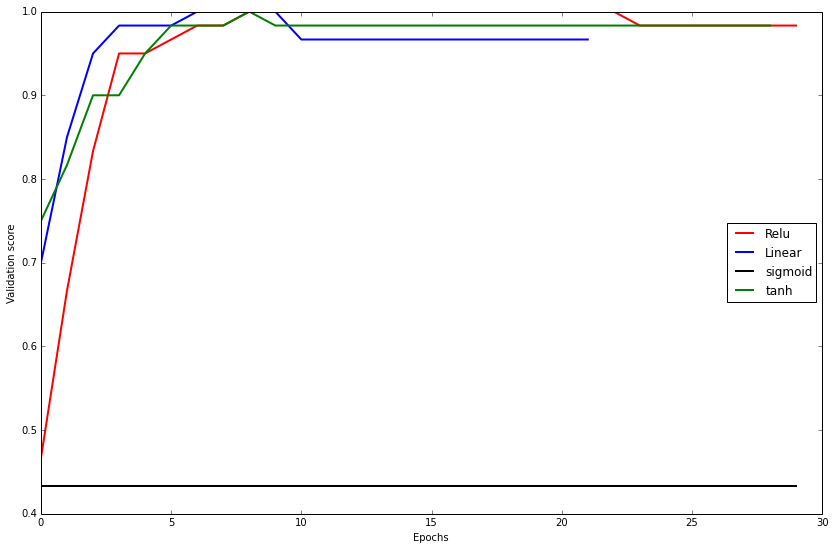

In [147]:
# Create the plot
plt.figure(figsize=(14,9))
plt.plot(history.history['val_acc'], 'r', label='Relu', lw=2, markersize=20)
plt.plot(history2.history['val_acc'], 'b', label='Linear', lw=2, markersize=20)
plt.plot(history3.history['val_acc'], 'k', label='sigmoid', lw=2, markersize=20)
plt.plot(history4.history['val_acc'], 'g', label='tanh', lw=2, markersize=20)
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.legend(loc='center right')

In [145]:
history.history['val_loss']

[0.6301440676053365,
 0.6030109206835429,
 0.5765442768732707,
 0.5512085080146789,
 0.5279515643914541,
 0.5059018572171529,
 0.4811014135678609,
 0.4541200836499532,
 0.4259432117144267,
 0.3968345026175181,
 0.36922510067621866,
 0.3414810299873352,
 0.31498793363571165,
 0.28944194118181865,
 0.2653049846490224,
 0.24487692415714263,
 0.22668801744778952,
 0.20962438583374024,
 0.19349464078744252,
 0.17972768346468607,
 0.16867620944976808,
 0.15766164163748422,
 0.1490221490462621,
 0.1417228231827418,
 0.13485978047053018,
 0.12901588181654614,
 0.12542775571346282,
 0.12117960949738821,
 0.11587478915850322,
 0.11121818224589029]